# Solve the KdV equation

$$
u_t + c u_x + \alpha u u_x + \beta u_{xxx} = r(x)A
$$

Add a dissipation term.

Holloway 1997

$$
KDV = \frac{k c }{H^2}A|A|
$$

Zulberti and Rayson 2028

$$
KDV = \frac{A^2}{H \tau}
$$

where $\tau$ is a dissipation time scale inferred from field observations of total energy on total dissipation averaged over a wave i.e.,

$$
\tau = E/\varepsilon
$$

In [1]:
import time
import numpy as np
import dedalus.public as de
from dedalus.tools  import post

from dedalus.extras.plot_tools import quad_mesh, pad_limits


import logging
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

In [2]:
%matplotlib notebook


In [3]:
# Input parameters
L = 1.2e5
nx = 1024

alpha = 1e-2
beta = 1e3
c = 1.1

decay_time = 1e10

spongetime = 600.
spongedist = 2e4

H = 250.

nu_H = 1.0

# BC parameters
a0 = 30.
omega= 2*np.pi/(12.42*3600.)

In [4]:
2*L/nx

234.375

In [14]:
# # CReate the domain
# x = de.Chebyshev('x',nx,interval=[0.,L])
# domain = de.Domain([x], grid_dtype='float')

x_basis = de.Chebyshev('x', nx, interval=[0,L], dealias=3/2)
domain = de.Domain([x_basis], np.float64)
x = domain.grid(0)

In [15]:
# Create the problem
problem = de.IVP(domain, variables=['A','A_x','A_xx'])
problem.parameters['alpha'] = alpha
problem.parameters['beta'] = beta
problem.parameters['c'] = c
problem.parameters['a0'] = a0
problem.parameters['omega'] = omega

# Dissipation parameters
# problem.parameters['tau'] = decay_time
# problem.parameters['H'] = H
# problem.parameters['nu_H'] = 1.0

# # Add a spatially varying damping term (used to damp waves near the right boundary) 
ncc = domain.new_field(name = 'r')
ncc['g'] = np.exp(-6*(L-x)/spongedist)/spongetime
problem.parameters['r'] = ncc
#problem.parameters['r'] = 0


problem.add_equation('A_x - dx(A) = 0')
problem.add_equation('A_xx - dx(A_x) = 0')

# Dissipation term added
#problem.add_equation('dt(A) + c*dx(A) + beta*dx(A_xx) + r*A + nu_H*A_xx = -alpha*A*dx(A) - A*A/(H*tau)')

# Standard form with spatially-varying damping term
problem.add_equation('dt(A) + c*dx(A) + beta*dx(A_xx)+ r*A = -alpha*A*dx(A)')

# Standard form
#problem.add_equation('dt(A) + c*dx(A) + beta*dx(A_xx) = -alpha*A*dx(A)')



# Add the time varying boundary conditions
problem.add_bc('left(A) = a0*sin(omega*t)')
#problem.add_bc('right(A_xx) = dx(right(A_x))')
#problem.add_bc('right(A_xx) = dx(right(A_x))')
problem.add_bc('right(A_xx) = 0')
problem.add_bc('right(A_x) = 0')

problem.meta[:]['x']['dirichlet'] = True

<IPython.core.display.Javascript object>


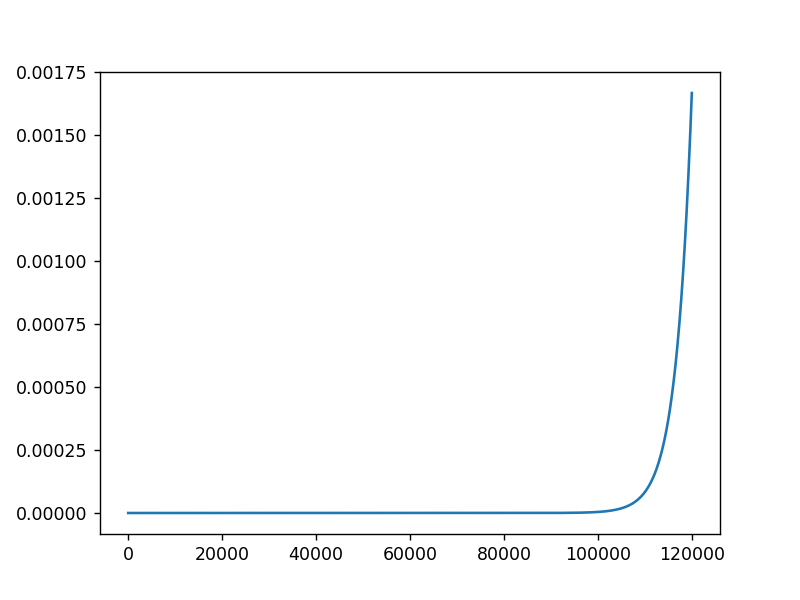

In [16]:
plt.figure()
plt.plot(x,ncc['g'])

In [17]:
solver = problem.build_solver(de.timesteppers.SBDF2)

solver.stop_sim_time = 1.5*86400
solver.stop_wall_time = 1000.
solver.stop_iteration = np.inf
dt = 5.

# Store data for final plot
# Initial conditions (scales parameter interpolates onto a finer grid)
x = domain.grids(scales=4)[0]
A = solver.state['A']

A.set_scales(4, keep_data=True)
A_list = [np.copy(A['g'])]
t_list = [solver.sim_time]

start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 200 == 0:
        logger.info("Time step {}".format(solver.iteration))
    
    if solver.iteration % 20 == 0:
        A.set_scales(4, keep_data=True)
        A_list.append(np.copy(A['g']))
        t_list.append(solver.sim_time)
end_time = time.time()

# Print statistics
logger.info('Total time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)
logger.info('Average timestep: %f' %(solver.sim_time/solver.iteration))

2020-03-16 01:43:45,522 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+00/s
2020-03-16 01:43:52,031 __main__ 0/1 INFO :: Time step 200
2020-03-16 01:43:59,164 __main__ 0/1 INFO :: Time step 400
2020-03-16 01:44:05,541 __main__ 0/1 INFO :: Time step 600
2020-03-16 01:44:15,397 __main__ 0/1 INFO :: Time step 800
2020-03-16 01:44:22,052 __main__ 0/1 INFO :: Time step 1000
2020-03-16 01:44:29,295 __main__ 0/1 INFO :: Time step 1200
2020-03-16 01:44:36,543 __main__ 0/1 INFO :: Time step 1400
2020-03-16 01:44:43,561 __main__ 0/1 INFO :: Time step 1600
2020-03-16 01:44:50,426 __main__ 0/1 INFO :: Time step 1800
2020-03-16 01:44:57,770 __main__ 0/1 INFO :: Time step 2000
2020-03-16 01:45:04,568 __main__ 0/1 INFO :: Time step 2200
2020-03-16 01:45:11,472 __main__ 0/1 INFO :: Time step 2400
2020-03-16 01:45:18,195 __main__ 0/1 INFO :: Time step 2600
2020-03-16 01:45:24,914 __main__ 0/1 INFO :: Time step 2800
2020-03-16 01:45:31,948 __main__ 0/1 INFO 

In [18]:
A_array = np.array(A_list)
t_array = np.array(t_list)
zmesh, tmesh = quad_mesh(x=x, y=t_array)

<IPython.core.display.Javascript object>


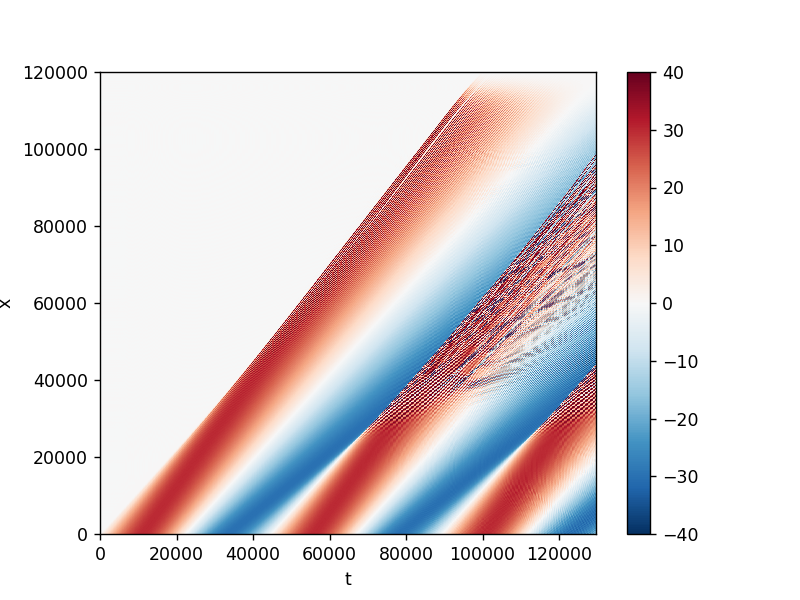

In [19]:
plt.figure()
plt.pcolormesh(tmesh.T, zmesh.T, A_array.T, cmap='RdBu_r',vmin=-40,vmax=40)
plt.axis(pad_limits(tmesh, zmesh))
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')

plt.show()

<IPython.core.display.Javascript object>


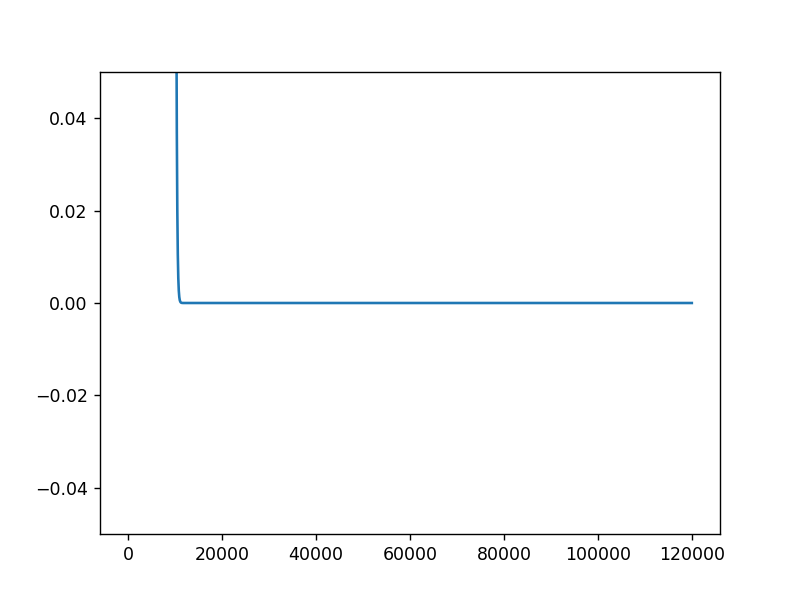

(-0.05, 0.05)

In [22]:
plt.figure()
#plt.pcolormesh(tmesh.T, zmesh.T, A_array.T, cmap='RdBu_r',vmin=-40,vmax=40)
plt.plot(x,A_array[90,:])
plt.ylim(-0.05,0.05)

In [23]:
zmesh.shape, A_array.shape, x.shape

((1298, 4097), (1297, 4096), (4096,))